In [5]:
# Load Dataframe
import pandas as pd
DATA_PATH = "data/raw/HIV.csv"
data = pd.read_csv(DATA_PATH)
data.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [6]:
# General information about the dataset
print(data.shape)
print(data['HIV_active'].value_counts())

(41127, 3)
0    39684
1     1443
Name: HIV_active, dtype: int64


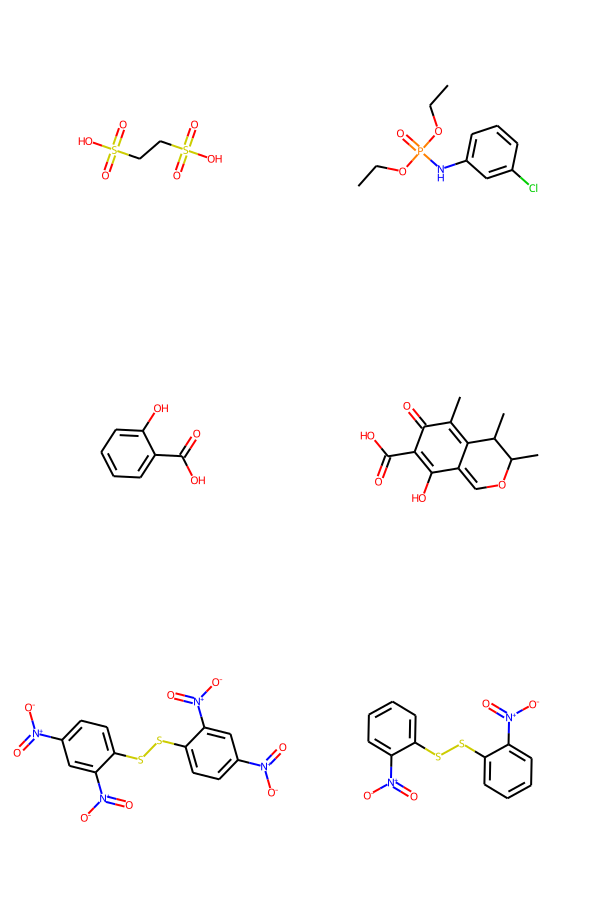

In [13]:
# Show sample molecules
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

sample_smiles = data["smiles"][4:10].values
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                            molsPerRow=2,
                            subImgSize=(300, 300))
grid

In [18]:
import os
import torch
import numpy as np
import torch_geometric
from rdkit import Chem
from tqdm.notebook import tqdm
from torch_geometric.data import Data, Dataset

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
CUDA available: True
Torch geometric version: 2.0.4


In [19]:
class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.test = test
        self.filename = filename

    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get Node Features
            node_feats = self._get_node_features(mol_obj)
            # Get Edge Features
            edge_feats = self._get_edge_features(mol_obj)
            # Get Adjacency Info
            edge_index = self._get_adjacency_indo(mol_obj)
            # Get Labels info
            label = self._get_labels(mol["HIV_active"])

            # Create Data Object
            data = Data(x=node_feats,
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"])
            if self.test:
                torch.save(data,
                           os.path.join(self.processed_dir,
                                        f'data_test_{index}.pt'))
            else:
                torch.save(data,
                           os.path.join(self.processed_dir,
                                        f'data_{index}.pt'))


    def _get_node_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)
        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []
        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]
        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data